# 1. 데이터셋 살펴보기

In [1]:
import os
import pandas as pd

In [2]:
data_dir = '../../data/DRIVING-DATASET/Detection/'
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
data_df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [3]:
# 이미지 한개 살펴보기
index = 859
img_files = [fn for fn in os.listdir(os.path.join(data_dir,'images')) if fn.endswith('jpg')] #이미지들 리스트
img_file = img_files[index]
img_path = os.path.join(data_dir,'images' ,img_file)

In [4]:
img_path

'../../data/DRIVING-DATASET/Detection/images/566c8099bce5f4f0.jpg'

In [5]:
import cv2
import matplotlib.pyplot as plt

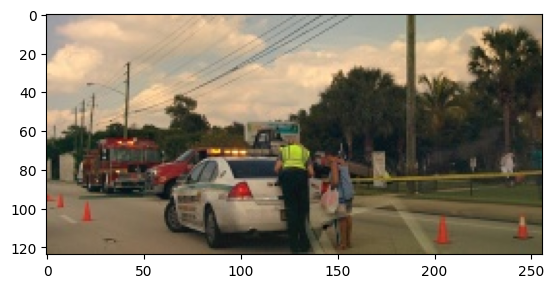

In [6]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [15]:
# 바운딩 박스 그리기

BOX_COLOR = {'Bus':(200, 0, 0), 'Truck':(0, 0, 200)}

def visualize(image, bounding_boxes,class_names,color=BOX_COLOR, thickness=2):
    for class_name, bounding_box in zip(class_names,bounding_boxes): 
        x_min, x_max, y_min, y_max = map(int,bounding_box) #정수의 값을 넣어야 그려짐
        
    
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color[class_name], thickness=thickness)
        
        ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
        cv2.rectangle(image, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color[class_name], -1)
        cv2.putText(
            image,
            text=class_name,
            org=(x_min, y_min - int(0.3 * text_height)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.35, 
            color=(255,255,255), 
            lineType=cv2.LINE_AA,
        )
    return image

In [16]:
CLASS_NAME_TO_ID = {'Bus': 0, 'Truck': 1} # 버스, 트럭의 키값을 가진 딕셔너리 -> string의 classid를 수치화하기위함

In [17]:
# 이미지 그리기 위한 데이터
img_id = img_file.split('.')[0]
img_df = data_df[data_df['ImageID']==img_id]
class_name = img_df['LabelName'].values
bounding_box = img_df[["XMin", "XMax", "YMin", "YMax"]].values

In [18]:
class_name

array(['Truck', 'Truck'], dtype=object)

In [19]:
# 이미지 크기에 따라서 노멀라이즈 되어있음, 이미지 크기를 곱해서 반환해서 사용해야함
bounding_box

array([[0.060625, 0.243125, 0.503866, 0.764175],
       [0.19625 , 0.470625, 0.554124, 0.770619]])

In [20]:
img_h, img_w, _ = img.shape

class_id = CLASS_NAME_TO_ID[class_name[0]]

# 노멀라이즈 되어있는 바운딩 박스의 좌표를 복원

bounding_box[:,[0,1]] *= img_w
bounding_box[:,[2,3]] *= img_h

In [21]:
bounding_box

array([[ 15.52    ,  62.24    ,  62.479384,  94.7577  ],
       [ 50.24    , 120.48    ,  68.711376,  95.556756]])

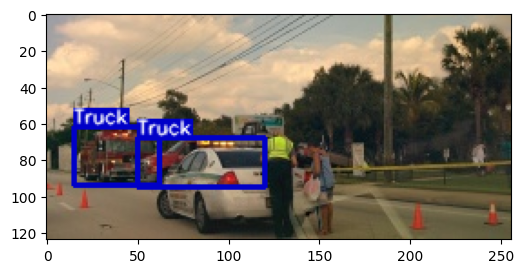

In [22]:
canvas = visualize(img, bounding_box, class_name)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [23]:
# 인덱스별 이미지 확인
from ipywidgets import interact
img_files = [fn for fn in os.listdir(os.path.join(data_dir,'images')) if fn.endswith('jpg')] #이미지들 리스트

In [24]:
@interact(index=(0, len(img_files)-1))
def show_imgbox(index=0):
    img_file = img_files[index]
    img_path = os.path.join(data_dir, 'images',img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    

    img_id = img_file.split('.')[0]
    img_df = data_df[data_df['ImageID']==img_id]
    bounding_box = img_df[['XMin','XMax','YMin','YMax']].values

    img_h, img_w, _ = img.shape
    bounding_box[:,[0,1]] *= img_w
    bounding_box[:,[2,3]] *= img_h   
    
    class_name = img_df['LabelName'].values

    canvas = visualize(img, bounding_box, class_name)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=15224), Output()), _dom_classes=('widget-int…